In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [135]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [136]:
batch_size = 50
epochs = 20
particles = 50
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [137]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [138]:
delta = 0.005
h_0 = 1
epsilon = 0.5

In [139]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [140]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [141]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [142]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 977us/step - loss: 2.2997 - accuracy: 0.0980


In [143]:
import time
start_time = time.time()

In [144]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)                              
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [145]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 887.102846622467


In [146]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 2.1473 - accuracy: 0.2780
0.27799999713897705
16/16 [==============================] - 0s 3ms/step - loss: 2.1462 - accuracy: 0.2780
0.27799999713897705
16/16 [==============================] - 0s 2ms/step - loss: 2.1502 - accuracy: 0.2860
0.28600001335144043
16/16 [==============================] - 0s 2ms/step - loss: 2.1463 - accuracy: 0.2780
0.27799999713897705
16/16 [==============================] - 0s 2ms/step - loss: 2.1475 - accuracy: 0.2800
0.2800000011920929
16/16 [==============================] - 0s 2ms/step - loss: 2.1479 - accuracy: 0.2860
0.28600001335144043
16/16 [==============================] - 0s 2ms/step - loss: 2.1497 - accuracy: 0.2820
0.28200000524520874
16/16 [==============================] - 0s 2ms/step - loss: 2.1478 - accuracy: 0.2780
0.27799999713897705
16/16 [==============================] - 0s 2ms/step - loss: 2.1502 - accuracy: 0.2820
0.28200000524520874
16/16 [==============================]

In [147]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84e645608>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e85081e8c8>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e86542a748>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84eb8f408>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84e59f048>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e841885148>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e841885b88>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84eabc788>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e844e9bb08>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84b4b8908>,
 'model_11': <tensorflow.python.keras.engine.sequential.Sequential at 0x1e84d72f248>,
 'model_12': <tensorflow.python.keras.engine.sequential.Sequent

In [148]:
model_dict["model_1"].get_weights()

[array([[-0.08248252,  0.06241529,  0.07638675, ...,  0.08444898,
          0.00230552, -0.05680018],
        [-0.00896566, -0.03533991,  0.04894847, ...,  0.00841722,
          0.03450258, -0.01703712],
        [-0.0181837 ,  0.05834354, -0.01594731, ..., -0.00158959,
         -0.0462005 ,  0.08543808],
        ...,
        [-0.06552644, -0.0738662 ,  0.02163556, ..., -0.00742543,
         -0.10753263, -0.03700101],
        [-0.00858406, -0.00920372,  0.1307592 , ..., -0.00030941,
         -0.00174992, -0.01950247],
        [ 0.02983563,  0.09885035, -0.12460903, ..., -0.02028275,
          0.02003356, -0.0730147 ]], dtype=float32),
 array([-0.04622805,  0.07103711,  0.06408818, -0.09313778, -0.09932314,
        -0.05190831,  0.12047115,  0.02313949, -0.04227088, -0.01115397,
        -0.01060487, -0.12222719,  0.00675019, -0.06695984, -0.0245691 ,
        -0.02759853, -0.28698036, -0.06120785,  0.08651167,  0.02646592,
         0.02275373,  0.05780708, -0.04545353, -0.15519743,  0.003

In [149]:
y_pred_dict["model_1"]

array([[0.01951076, 0.0247129 , 0.01822745, 0.0363811 , 0.10060172,
        0.00647314, 0.12010582, 0.36136213, 0.04533785, 0.26728708],
       [0.05694989, 0.12911373, 0.07106558, 0.13296565, 0.13575532,
        0.04664496, 0.21565865, 0.07887379, 0.06351361, 0.06945886],
       [0.12128965, 0.11299667, 0.06172535, 0.1611973 , 0.04286133,
        0.1115384 , 0.18703555, 0.07092781, 0.05333431, 0.07709355],
       [0.09506042, 0.06693952, 0.09287429, 0.05808586, 0.0487051 ,
        0.03324645, 0.10620093, 0.40470505, 0.02972676, 0.06445566],
       [0.08446492, 0.02343934, 0.07665444, 0.03489729, 0.09272294,
        0.03830579, 0.05113389, 0.1800359 , 0.06923557, 0.3491099 ],
       [0.0144357 , 0.02108034, 0.40420836, 0.2840731 , 0.0522876 ,
        0.0647275 , 0.02749276, 0.07308538, 0.05610311, 0.00250612],
       [0.10663938, 0.08145557, 0.08877894, 0.07001226, 0.11271065,
        0.08660129, 0.07457342, 0.17900804, 0.05197665, 0.14824374],
       [0.16513154, 0.07483439, 0.0692428

In [150]:
jacobian_dict["model_1"]

array([[ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -2.7295399,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -4.5318866,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -8.580862 ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -2.4407804,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -5.4043565,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -2.4437428,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -5.4345455

In [151]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.117      0.103      0.12800001 0.16599999 0.189      0.193
 0.20999999 0.23       0.233      0.23100001 0.237      0.243
 0.245      0.242      0.245      0.25       0.25099999 0.25
 0.249      0.25       0.249     ]
[0.098      0.088      0.138      0.134      0.15000001 0.178
 0.19400001 0.212      0.222      0.23199999 0.23999999 0.25400001
 0.25999999 0.266      0.266      0.27200001 0.27599999 0.27599999
 0.278      0.28200001 0.28200001]


In [152]:
train_acc_dict

{'model_1': [0.11100000143051147,
  0.1469999998807907,
  0.15700000524520874,
  0.17000000178813934,
  0.2029999941587448,
  0.2160000056028366,
  0.21799999475479126,
  0.22599999606609344,
  0.2280000001192093,
  0.2280000001192093,
  0.23000000417232513,
  0.24199999868869781,
  0.23800000548362732,
  0.23899999260902405,
  0.23999999463558197,
  0.2409999966621399,
  0.24400000274181366,
  0.24699999392032623,
  0.24500000476837158,
  0.2460000067949295],
 'model_2': [0.10599999874830246,
  0.13600000739097595,
  0.1509999930858612,
  0.17499999701976776,
  0.1979999989271164,
  0.210999995470047,
  0.22200000286102295,
  0.23499999940395355,
  0.23100000619888306,
  0.24500000476837158,
  0.24199999868869781,
  0.24199999868869781,
  0.24500000476837158,
  0.24799999594688416,
  0.25099998712539673,
  0.25200000405311584,
  0.25099998712539673,
  0.25200000405311584,
  0.25,
  0.2529999911785126],
 'model_3': [0.10999999940395355,
  0.13500000536441803,
  0.14000000059604645,
  0

In [153]:
test_acc_dict

{'model_1': [0.12999999523162842,
  0.15000000596046448,
  0.164000004529953,
  0.1599999964237213,
  0.18400000035762787,
  0.20800000429153442,
  0.23000000417232513,
  0.23999999463558197,
  0.23999999463558197,
  0.25,
  0.257999986410141,
  0.25600001215934753,
  0.257999986410141,
  0.2619999945163727,
  0.2720000147819519,
  0.27000001072883606,
  0.27799999713897705,
  0.2800000011920929,
  0.2800000011920929,
  0.27799999713897705],
 'model_2': [0.0860000029206276,
  0.12200000137090683,
  0.12399999797344208,
  0.13600000739097595,
  0.1459999978542328,
  0.18799999356269836,
  0.20200000703334808,
  0.22599999606609344,
  0.23999999463558197,
  0.24400000274181366,
  0.257999986410141,
  0.25999999046325684,
  0.2680000066757202,
  0.2759999930858612,
  0.28200000524520874,
  0.28200000524520874,
  0.28600001335144043,
  0.28200000524520874,
  0.27799999713897705,
  0.27799999713897705],
 'model_3': [0.07400000095367432,
  0.11400000005960464,
  0.11999999731779099,
  0.1539

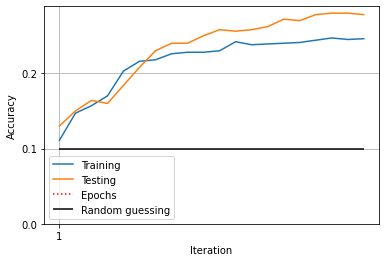

In [154]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

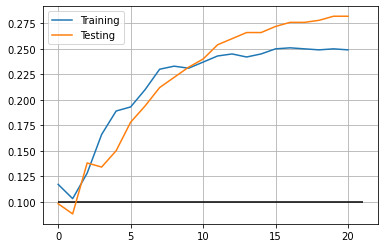

In [155]:
plt.plot(np.arange(len(mean_model_train_acc)), mean_model_train_acc, label = "Training")
plt.plot(np.arange(len(mean_model_test_acc)), mean_model_test_acc, label = "Testing")
plt.hlines(xmin = 0, xmax = len(mean_model_train_acc), y = 0.1, color = "black")
plt.legend()
plt.grid()
plt.show()